Training Baseline Model : Linear Regression from scikit-learn

In [187]:
# install dependencies
# %pip install pandas scikit-learn timm matplotlib
# %pip install ipywidgets
# %pip install seaborn

In [188]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import time
import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

In [189]:
class YoutubeDataset(Dataset):
    def __init__(self, data, doc2vec, image_option=True):
        self.ids = list(data['video_id'])
        self.titles = doc2vec # pretrained doc2vec features
        self.data = data # video_id, metadata, views(y) from csv file
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.transform = transforms.ToTensor()
        self.image_option = image_option

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # index order of video_id, meta, y are same
        video_id = self.ids[idx]
        
        if self.image_option:
            image = Image.open('/mnt/medium_15287/{}.jpg'.format(video_id)) # load image
            image = self.transform(image)
            image = image.to(self.device)
        else:
            image = torch.zeros((3, 180, 320), dtype=torch.float)
        
        title = self.titles[video_id] # get video title
        title = torch.FloatTensor(np.array(title, dtype=np.float16))
        
        meta = torch.FloatTensor(self.data[['period_day', 'subscriber_count']].to_numpy()[idx]) # get metadata
        
        y = np.log10(self.data['views'].to_numpy() + 1) # add 1 for zero views
        y = np.expand_dims(y, axis=1) # add batch dimension
        y = torch.FloatTensor(y[idx]) # get log10(views+1) by idx value
        
        return video_id, image, title, meta, y

In [190]:
class Model(nn.Module):
    def __init__(self, use_image=True):
        super(Model, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.fc1 = nn.Linear(172812, 1) # using image
        self.fc2 = nn.Linear(12, 1) # not using image
        self.use_image = use_image
    
    def forward(self, feature_map, title, meta):
        if self.use_image:
            feature_map, title, meta = feature_map.to(self.device), title.to(self.device), meta.to(self.device)
            feature_map = torch.flatten(feature_map, start_dim=1)
            x = torch.cat([feature_map, title, meta], dim=1)
            x = self.fc1(x)
            return x
        else:
            title, meta = title.to(self.device), meta.to(self.device)
            x = torch.cat([title, meta], dim=1)
            x = self.fc2(x)
            return x

    def train_(self, epochs, lr, train_loader, valid_loader, save_every):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss_log = []
        self.train_mse_log = []
        self.valid_mse_log = []

        best_mse = 1e100
        best_epoch = 1

        train_start = time.time()

        print("Model will be trained on {}\n".format(self.device))

        for epoch in range(1, epochs + 1):
            self.train()
            print("[Epoch {:3d} / {}]".format(epoch, epochs))

            epoch_start = time.time()
            epoch_loss = 0.0
            epoch_mse = 0.0
            
            #training
            for batch_idx, batch_data in enumerate(tqdm(train_loader, desc="Training")):
                batch_video_id, batch_image, batch_title, batch_meta, batch_target = batch_data
                batch_target = batch_target.to(self.device)
                
                self.optimizer.zero_grad()
                output = self.forward(batch_image, batch_title, batch_meta)
                loss = self.criterion(output, batch_target)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                epoch_mse += loss.item()

                # print('Epoch : {}, mini-batch : {}, loss : {}'.format(epoch, batch_idx, loss.item()))

            epoch_end = time.time()
            m, s = divmod(epoch_end - epoch_start, 60)
            
            epoch_loss /= len(train_loader)
            epoch_mse /= len(train_loader)
            self.train_loss_log.append(epoch_loss)
            self.train_mse_log.append(epoch_mse)
            
            #validation
            with torch.no_grad():
                self.eval()
                true_y, pred_y = self.predict(valid_loader)                
                true_y = torch.FloatTensor(true_y)
                pred_y = torch.FloatTensor(pred_y)
                valid_mse = self.criterion(pred_y, true_y)
                self.valid_mse_log.append(valid_mse.item())

            print("Train MSE = {:.4f} | Valid MSE = {:.4f}".format(epoch_mse, valid_mse))
            print(f"Train Time: {m:.0f}m {s:.0f}s\n")

            valid_mse = valid_mse.item()
            if best_mse > valid_mse:
                print("=> Best Model Updated : Epoch = {}, Valid MSE = {:.4f}\n".format(epoch, valid_mse))
                best_mse = valid_mse
                best_epoch = epoch
                torch.save(self.state_dict(), "./best_model/best_model.pt")
            else:
                print()

            # save model for every ? epoch
            if (epoch % save_every) == 0:
                torch.save(self.state_dict(),"./model/epoch{}_train-mse{:.4f}_valid-mse{:.4f}.pt".format(epoch, epoch_mse, valid_mse))

        m, s = divmod(time.time() - train_start, 60)
        print("\nTraining Finished...!!")
        print("\nBest Valid MSE : %.2f at epoch %d" % (best_mse, best_epoch))
        print(f"Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {self.device}!")

        torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))
    
    def restore(self):
        with open("./best_model/best_model.pt", "rb") as f:
            state_dict = torch.load(f)
        self.load_state_dict(state_dict)

    def predict(self, dataloader):
        with torch.no_grad():
            self.eval()
            true_y = []
            pred_y = []
            for batch_video_id, batch_image, batch_title, batch_meta, batch_target in dataloader:
                pred = self.forward(batch_image, batch_title, batch_meta)
                true_y.append(batch_target.numpy())
                pred_y.append(pred.cpu().numpy())
            pred_y = np.concatenate(pred_y, axis=0)
            true_y = np.concatenate(true_y, axis=0)
        return pred_y, true_y #numpy array

    def plot(self, start=0, step=1):
        plt.figure(1)
        plt.plot(np.array(self.train_mse_log[start::step]), "b", label='Train MSE')
        plt.plot(np.array(self.valid_mse_log[start::step]), "r", label='Valid Mse')
        plt.legend()
        plt.title('MSE')
        plt.savefig("./mse-graph.png")
        
        plt.figure(2)
        plt.plot(np.array(self.train_loss_log[start::step]), "g", label='Train Loss')
        plt.legend()
        plt.title('Train Loss')
        plt.savefig("./loss-graph.png")
        
        plt.show()


In [191]:
%cd /mnt

/mnt


In [192]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

Train Data Statistics before Normalization
mean period :  335.83891836883043
std period :  497.77141615927457
mean subscriber :  1784439.962419132
std subscriber :  3833901.649291374


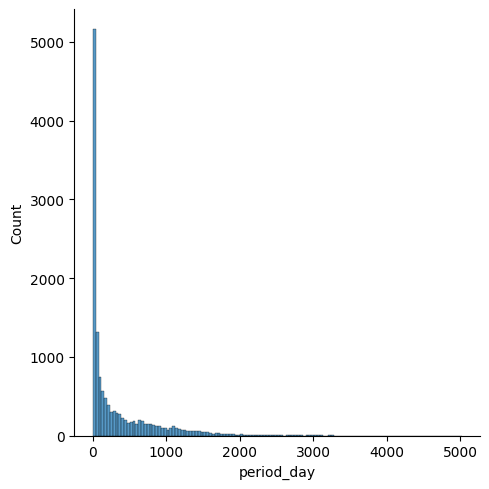

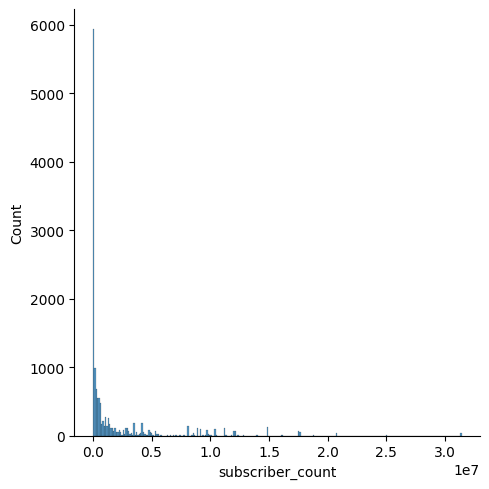

In [193]:
# before normalization
sns.displot(train_data["period_day"])
sns.displot(train_data["subscriber_count"])

mean_period = train_data['period_day'].mean()
std_period = train_data['period_day'].std()
mean_subscriber = train_data['subscriber_count'].mean()
std_subscriber = train_data['subscriber_count'].std()

print('Train Data Statistics before Normalization')
print("mean period : ", mean_period)
print("std period : ", std_period)
print("mean subscriber : ", mean_subscriber)
print("std subscriber : ", std_subscriber)

In [194]:
# train data nomarlization
train_data['period_day'] = (train_data['period_day'] - mean_period) / std_period
train_data['subscriber_count'] = (train_data['subscriber_count'] - mean_subscriber) / std_subscriber

# test data nomarlization
test_data['period_day'] = (test_data['period_day'] - mean_period) / std_period
test_data['subscriber_count'] = (test_data['subscriber_count'] - mean_subscriber) / std_subscriber

Train Data Statistics after Normalization
mean period :  -5.784748593816327e-17
std period :  1.0
mean subscriber :  2.685776132843295e-17
std subscriber :  1.0


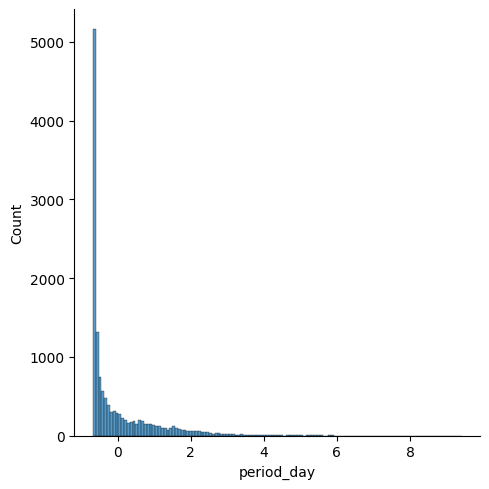

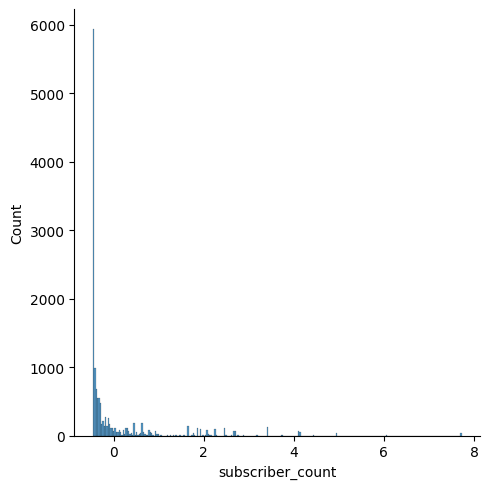

In [195]:
# after normalization
sns.displot(train_data["period_day"])
sns.displot(train_data["subscriber_count"])

mean_period = train_data['period_day'].mean()
std_period = train_data['period_day'].std()
mean_subscriber = train_data['subscriber_count'].mean()
std_subscriber = train_data['subscriber_count'].std()

print('Train Data Statistics after Normalization')
print("mean period : ", mean_period)
print("std period : ", std_period)
print("mean subscriber : ", mean_subscriber)
print("std subscriber : ", std_subscriber)

In [196]:
# split train -> train : valid = 9 : 1
train_data, valid_data = train_test_split(train_data, test_size = 0.1, random_state = 55)
print('Train Dataset Size : ',len(train_data))
print('Validation Dataset Size : ',len(valid_data))
print('Test Dataset Size : ',len(test_data))

Train Dataset Size :  12381
Validation Dataset Size :  1376
Test Dataset Size :  1529


In [197]:
# open doc2vec data and convert to dict
with open('./title_doc2vec_10', 'rb') as f:
    doc2vec = pickle.load(f)

data_dict=dict()
for row in doc2vec:
    vid=row[0]
    vec=row[1:]
    data_dict[vid]=vec

doc2vec = data_dict
print(len(doc2vec))

15287


In [198]:
#setting hyper parameters
batch_size = 64
epochs = 100
lr = 1e-5
save_every = 5

In [199]:
train_dataset = YoutubeDataset(train_data, doc2vec)
valid_dataset = YoutubeDataset(valid_data, doc2vec)
test_dataset = YoutubeDataset(test_data, doc2vec)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [200]:
model = Model(use_image=True)
model.to(model.device)
model.train_(epochs, lr, train_loader, valid_loader, save_every)

Model will be trained on cuda

[Epoch   1 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 3.2080 | Valid MSE = 2.7576
Train Time: 1m 16s

=> Best Model Updated : Epoch = 1, Valid MSE = 2.7576

[Epoch   2 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.5969 | Valid MSE = 2.6985
Train Time: 1m 15s

=> Best Model Updated : Epoch = 2, Valid MSE = 2.6985

[Epoch   3 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.5630 | Valid MSE = 2.7781
Train Time: 1m 15s


[Epoch   4 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.5080 | Valid MSE = 2.6476
Train Time: 1m 15s

=> Best Model Updated : Epoch = 4, Valid MSE = 2.6476

[Epoch   5 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.4780 | Valid MSE = 2.6184
Train Time: 1m 15s

=> Best Model Updated : Epoch = 5, Valid MSE = 2.6184

[Epoch   6 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.4587 | Valid MSE = 2.6352
Train Time: 1m 15s


[Epoch   7 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.4157 | Valid MSE = 2.6372
Train Time: 1m 14s


[Epoch   8 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.3878 | Valid MSE = 2.6339
Train Time: 1m 14s


[Epoch   9 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.3742 | Valid MSE = 2.6728
Train Time: 1m 14s


[Epoch  10 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.3340 | Valid MSE = 2.6895
Train Time: 1m 13s


[Epoch  11 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.3276 | Valid MSE = 2.6430
Train Time: 1m 18s


[Epoch  12 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.2877 | Valid MSE = 2.7755
Train Time: 1m 16s


[Epoch  13 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.2815 | Valid MSE = 2.5855
Train Time: 1m 15s

=> Best Model Updated : Epoch = 13, Valid MSE = 2.5855

[Epoch  14 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.3036 | Valid MSE = 2.7509
Train Time: 1m 16s


[Epoch  15 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.2215 | Valid MSE = 2.6872
Train Time: 1m 16s


[Epoch  16 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.2057 | Valid MSE = 2.6522
Train Time: 1m 15s


[Epoch  17 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1843 | Valid MSE = 2.7891
Train Time: 1m 16s


[Epoch  18 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1890 | Valid MSE = 2.6399
Train Time: 1m 16s


[Epoch  19 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1284 | Valid MSE = 2.6147
Train Time: 1m 15s


[Epoch  20 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1195 | Valid MSE = 2.5774
Train Time: 1m 16s

=> Best Model Updated : Epoch = 20, Valid MSE = 2.5774

[Epoch  21 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1101 | Valid MSE = 2.6869
Train Time: 1m 15s


[Epoch  22 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.1271 | Valid MSE = 2.5846
Train Time: 1m 16s


[Epoch  23 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.0788 | Valid MSE = 2.6002
Train Time: 1m 16s


[Epoch  24 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.0601 | Valid MSE = 2.5956
Train Time: 1m 16s


[Epoch  25 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.0139 | Valid MSE = 2.5831
Train Time: 1m 16s


[Epoch  26 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 2.0228 | Valid MSE = 2.5465
Train Time: 1m 17s

=> Best Model Updated : Epoch = 26, Valid MSE = 2.5465

[Epoch  27 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9850 | Valid MSE = 2.5525
Train Time: 1m 17s


[Epoch  28 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9865 | Valid MSE = 2.5413
Train Time: 1m 17s

=> Best Model Updated : Epoch = 28, Valid MSE = 2.5413

[Epoch  29 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9686 | Valid MSE = 2.5598
Train Time: 1m 17s


[Epoch  30 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9481 | Valid MSE = 2.7252
Train Time: 1m 17s


[Epoch  31 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9650 | Valid MSE = 2.5448
Train Time: 1m 17s


[Epoch  32 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9334 | Valid MSE = 2.5461
Train Time: 1m 17s


[Epoch  33 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.9015 | Valid MSE = 2.5276
Train Time: 1m 17s

=> Best Model Updated : Epoch = 33, Valid MSE = 2.5276

[Epoch  34 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8763 | Valid MSE = 2.5398
Train Time: 1m 17s


[Epoch  35 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8757 | Valid MSE = 2.5495
Train Time: 1m 17s


[Epoch  36 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8436 | Valid MSE = 2.7105
Train Time: 1m 17s


[Epoch  37 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8413 | Valid MSE = 2.5436
Train Time: 1m 17s


[Epoch  38 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8239 | Valid MSE = 2.5469
Train Time: 1m 16s


[Epoch  39 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.8435 | Valid MSE = 2.5300
Train Time: 1m 16s


[Epoch  40 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7997 | Valid MSE = 2.5342
Train Time: 1m 17s


[Epoch  41 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7875 | Valid MSE = 2.5388
Train Time: 1m 16s


[Epoch  42 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7739 | Valid MSE = 2.5142
Train Time: 1m 16s

=> Best Model Updated : Epoch = 42, Valid MSE = 2.5142

[Epoch  43 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7758 | Valid MSE = 2.5191
Train Time: 1m 16s


[Epoch  44 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7487 | Valid MSE = 2.6822
Train Time: 1m 17s


[Epoch  45 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7364 | Valid MSE = 2.5108
Train Time: 1m 16s

=> Best Model Updated : Epoch = 45, Valid MSE = 2.5108

[Epoch  46 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7309 | Valid MSE = 2.5691
Train Time: 1m 16s


[Epoch  47 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7182 | Valid MSE = 2.5323
Train Time: 1m 17s


[Epoch  48 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7094 | Valid MSE = 2.5240
Train Time: 1m 17s


[Epoch  49 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.7316 | Valid MSE = 2.5088
Train Time: 1m 17s

=> Best Model Updated : Epoch = 49, Valid MSE = 2.5088

[Epoch  50 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6511 | Valid MSE = 2.6396
Train Time: 1m 17s


[Epoch  51 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6646 | Valid MSE = 2.5010
Train Time: 1m 16s

=> Best Model Updated : Epoch = 51, Valid MSE = 2.5010

[Epoch  52 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6568 | Valid MSE = 2.7125
Train Time: 1m 16s


[Epoch  53 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6334 | Valid MSE = 2.5045
Train Time: 1m 17s


[Epoch  54 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6351 | Valid MSE = 2.5566
Train Time: 1m 16s


[Epoch  55 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6291 | Valid MSE = 2.4873
Train Time: 1m 17s

=> Best Model Updated : Epoch = 55, Valid MSE = 2.4873

[Epoch  56 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6061 | Valid MSE = 2.5290
Train Time: 1m 16s


[Epoch  57 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6154 | Valid MSE = 2.5403
Train Time: 1m 17s


[Epoch  58 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5981 | Valid MSE = 2.6597
Train Time: 1m 16s


[Epoch  59 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.6201 | Valid MSE = 2.5274
Train Time: 1m 15s


[Epoch  60 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5618 | Valid MSE = 2.4925
Train Time: 1m 16s


[Epoch  61 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5518 | Valid MSE = 2.5092
Train Time: 1m 16s


[Epoch  62 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5416 | Valid MSE = 2.4969
Train Time: 1m 17s


[Epoch  63 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5379 | Valid MSE = 2.5812
Train Time: 1m 17s


[Epoch  64 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5263 | Valid MSE = 2.5348
Train Time: 1m 16s


[Epoch  65 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5125 | Valid MSE = 2.5029
Train Time: 1m 16s


[Epoch  66 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5028 | Valid MSE = 2.6089
Train Time: 1m 17s


[Epoch  67 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.5030 | Valid MSE = 2.4898
Train Time: 1m 16s


[Epoch  68 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4826 | Valid MSE = 2.5086
Train Time: 1m 17s


[Epoch  69 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4788 | Valid MSE = 2.4987
Train Time: 1m 16s


[Epoch  70 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4716 | Valid MSE = 2.6905
Train Time: 1m 16s


[Epoch  71 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4586 | Valid MSE = 2.4774
Train Time: 1m 16s

=> Best Model Updated : Epoch = 71, Valid MSE = 2.4774

[Epoch  72 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4552 | Valid MSE = 2.5118
Train Time: 1m 17s


[Epoch  73 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4548 | Valid MSE = 2.4761
Train Time: 1m 17s

=> Best Model Updated : Epoch = 73, Valid MSE = 2.4761

[Epoch  74 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4275 | Valid MSE = 2.4924
Train Time: 1m 16s


[Epoch  75 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4168 | Valid MSE = 2.5262
Train Time: 1m 16s


[Epoch  76 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4053 | Valid MSE = 2.5259
Train Time: 1m 16s


[Epoch  77 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4118 | Valid MSE = 2.5625
Train Time: 1m 17s


[Epoch  78 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.4017 | Valid MSE = 2.4762
Train Time: 1m 17s


[Epoch  79 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3763 | Valid MSE = 2.4739
Train Time: 1m 17s

=> Best Model Updated : Epoch = 79, Valid MSE = 2.4739

[Epoch  80 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3770 | Valid MSE = 2.4628
Train Time: 1m 17s

=> Best Model Updated : Epoch = 80, Valid MSE = 2.4628

[Epoch  81 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3589 | Valid MSE = 2.4853
Train Time: 1m 17s


[Epoch  82 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3676 | Valid MSE = 2.4686
Train Time: 1m 16s


[Epoch  83 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3671 | Valid MSE = 2.4776
Train Time: 1m 17s


[Epoch  84 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3325 | Valid MSE = 2.4771
Train Time: 1m 16s


[Epoch  85 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3710 | Valid MSE = 2.4876
Train Time: 1m 17s


[Epoch  86 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3157 | Valid MSE = 2.5097
Train Time: 1m 16s


[Epoch  87 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3264 | Valid MSE = 2.4568
Train Time: 1m 16s

=> Best Model Updated : Epoch = 87, Valid MSE = 2.4568

[Epoch  88 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3058 | Valid MSE = 2.4938
Train Time: 1m 15s


[Epoch  89 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3160 | Valid MSE = 2.4538
Train Time: 1m 16s

=> Best Model Updated : Epoch = 89, Valid MSE = 2.4538

[Epoch  90 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.3015 | Valid MSE = 2.4488
Train Time: 1m 17s

=> Best Model Updated : Epoch = 90, Valid MSE = 2.4488

[Epoch  91 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2809 | Valid MSE = 2.4985
Train Time: 1m 16s


[Epoch  92 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2717 | Valid MSE = 2.4506
Train Time: 1m 16s


[Epoch  93 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2734 | Valid MSE = 2.4635
Train Time: 1m 17s


[Epoch  94 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2584 | Valid MSE = 2.4649
Train Time: 1m 16s


[Epoch  95 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2616 | Valid MSE = 2.4641
Train Time: 1m 17s


[Epoch  96 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2381 | Valid MSE = 2.4558
Train Time: 1m 17s


[Epoch  97 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2634 | Valid MSE = 2.7359
Train Time: 1m 17s


[Epoch  98 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2646 | Valid MSE = 2.4572
Train Time: 1m 16s


[Epoch  99 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2403 | Valid MSE = 2.4497
Train Time: 1m 17s


[Epoch 100 / 100]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 1.2291 | Valid MSE = 2.4483
Train Time: 1m 17s

=> Best Model Updated : Epoch = 100, Valid MSE = 2.4483


Training Finished...!!

Best Valid MSE : 2.45 at epoch 100
Total Time: 140m 3s
Model was trained on cuda!


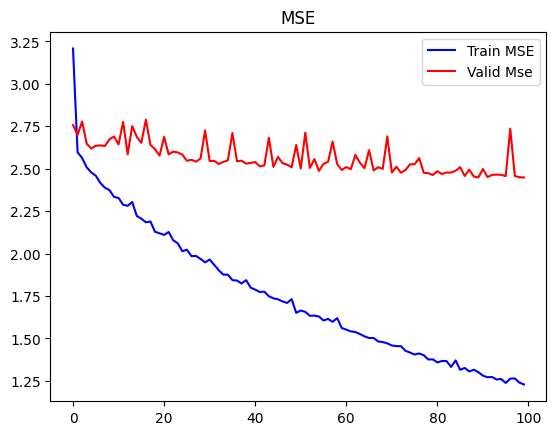

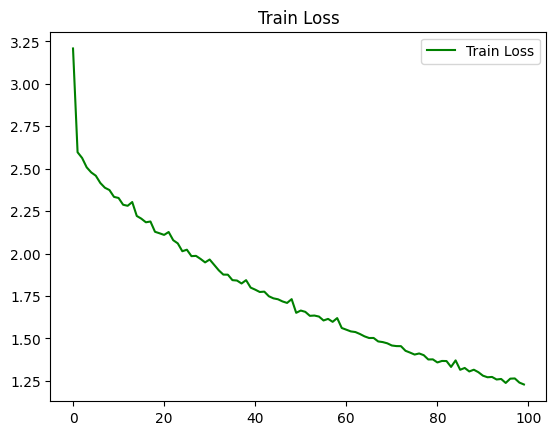

In [201]:
model.plot()

In [202]:
# test
model.restore() # load best model during training
pred_y, true_y = model.predict(test_loader)
true_y = torch.FloatTensor(true_y)
pred_y = torch.FloatTensor(pred_y)
test_mse = model.criterion(pred_y, true_y)
print('Test MSE : ',test_mse.item())

Test MSE :  2.339280605316162


In [203]:
# test with no image
no_image_test_dataset = YoutubeDataset(test_data, doc2vec, image_option=False)
no_image_test_loader = DataLoader(no_image_test_dataset, batch_size = batch_size)

model.restore() # load best model during training
pred_y, true_y = model.predict(no_image_test_loader)
true_y = torch.FloatTensor(true_y)
pred_y = torch.FloatTensor(pred_y)
test_mse = model.criterion(pred_y, true_y)
print('No Image Test MSE : ',test_mse.item())

No Image Test MSE :  23.068880081176758


In [204]:
# save best_model as script
model.restore()
model_script = torch.jit.script(model)
model_script.save('./best_model/best_model_script.pt')